# Exercises Chapter 6
Sanjay Jaras

In [1]:
%matplotlib inline

import numpy as np

import brfss

import thinkstats2
import thinkplot

I'll start with the data from the BRFSS again.

In [2]:
def RawMoment(xs, k):
    return sum(x**k for x in xs) / len(xs)

The first raw moment is the mean.  The other raw moments don't mean much.

In [3]:
def Mean(xs):
    return RawMoment(xs, 1)

The central moments are powers of distances from the mean.

In [4]:
def CentralMoment(xs, k):
    mean = RawMoment(xs, 1)
    return sum((x - mean)**k for x in xs) / len(xs)

The first central moment is approximately 0.  The second central moment is the variance.

In [5]:
def Var(xs):
    return CentralMoment(xs, 2)


The standardized moments are ratios of central moments, with powers chosen to make the dimensions cancel.

In [6]:
def StandardizedMoment(xs, k):
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    return CentralMoment(xs, k) / std**k

The third standardized moment is skewness.

In [7]:
def Skewness(xs):
    return StandardizedMoment(xs, 3)

Normally a negative skewness indicates that the distribution has a longer tail on the left.  In that case, the mean is usually less than the median.

In [8]:
def Median(xs):
    cdf = thinkstats2.Cdf(xs)
    return cdf.Value(0.5)

In [9]:
def PearsonMedianSkewness(xs):
    median = Median(xs)
    mean = RawMoment(xs, 1)
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    gp = 3 * (mean - median) / std
    return gp

Pearson's skewness is positive, indicating that the distribution of female heights is slightly skewed to the right.

### Exercises 6.1

The distribution of income is famously skewed to the right. In this exercise, we’ll measure how strong that skew is.
The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm. I downloaded `hinc06.xls`, which is an Excel spreadsheet with information about household income, and converted it to `hinc06.csv`, a CSV file you will find in the repository for this book. You will also find `hinc2.py`, which reads this file and transforms the data.

The dataset is in the form of a series of income ranges and the number of respondents who fell in each range. The lowest range includes respondents who reported annual household income “Under \$5000.” The highest range includes respondents who made “\$250,000 or more.”

To estimate mean and other statistics from these data, we have to make some assumptions about the lower and upper bounds, and how the values are distributed in each range. `hinc2.py` provides `InterpolateSample`, which shows one way to model this data. It takes a `DataFrame` with a column, `income`, that contains the upper bound of each range, and `freq`, which contains the number of respondents in each frame.

It also takes `log_upper`, which is an assumed upper bound on the highest range, expressed in `log10` dollars. The default value, `log_upper=6.0` represents the assumption that the largest income among the respondents is $10^6$, or one million dollars.

`InterpolateSample` generates a pseudo-sample; that is, a sample of household incomes that yields the same number of respondents in each range as the actual data. It assumes that incomes in each range are equally spaced on a `log10` scale.

In [10]:
def InterpolateSample(df, log_upper=6.0):
    """Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range

    returns: NumPy array of log10 household income
    """
    # compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)

    # get the lower bounds by shifting the upper bound and filling in
    # the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.loc[0, 'log_lower'] = 3.0

    # plug in a value for the unknown upper bound of the highest range
    df.loc[41, 'log_upper'] = log_upper
    
    # use the freq column to generate the right number of values in
    # each range
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, int(row.freq))
        arrays.append(vals)

    # collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    return log_sample


In [11]:
import hinc
income_df = hinc.ReadData()

In [12]:
log_sample = InterpolateSample(income_df, log_upper=6.0)

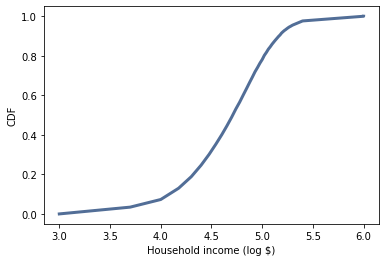

In [13]:
log_cdf = thinkstats2.Cdf(log_sample)
thinkplot.Cdf(log_cdf)
thinkplot.Config(xlabel='Household income (log $)',
               ylabel='CDF')

In [14]:
sample = np.power(10, log_sample)

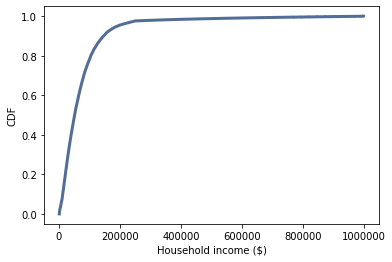

In [15]:
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income ($)',
               ylabel='CDF')

Compute the median, mean, skewness and Pearson’s skewness of the resulting sample. What fraction of households report a taxable income below the mean? How do the results depend on the assumed upper bound?

In [16]:
print("Mean for sample:", Mean(sample))
print("Median for sample:", Median(sample))

Mean for sample: 74278.70753118739
Median for sample: 51226.45447894046


In [17]:
print("Skewness for sample:", Skewness(sample))
print("Pearson’s Skewness for sample:", PearsonMedianSkewness(sample))

Skewness for sample: 4.949920244429579
Pearson’s Skewness for sample: 0.7361258019141795


In [18]:
mean = Mean(sample)
print("Percentage of People having income less than mean:", cdf.Prob(mean) * 100, "%")


Percentage of People having income less than mean: 66.0005879566872 %


All of this is based on an assumption that the highest income is one million dollars, but that's certainly not correct.  What happens to the skew if the upper bound is 10 million?

Without better information about the top of this distribution, we can't say much about the skewness of the distribution.

#### Following are the skewness with upper bound as 10 million, the strenght of the Pearson’s skwewness is reduced. 

In [19]:
log_sample = InterpolateSample(income_df, log_upper=7.0)
sample = np.power(10, log_sample)
print("Mean for sample:", Mean(sample))
print("Median for sample:", Median(sample))
print("Skewness for sample:", Skewness(sample))
print("Pearson’s Skewness for sample:", PearsonMedianSkewness(sample))

Mean for sample: 124267.39722164693
Median for sample: 51226.45447894046
Skewness for sample: 11.603690267537795
Pearson’s Skewness for sample: 0.39156450927742104
